In [1]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision.transforms.functional as f
import torch.utils.data as Data
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.autograd import Variable
import torch
import random

In [2]:
#x = torch.randint(1,10,[1,1,3]).float()
x = torch.randn(1,1,5)
#X = torch.tensor([[[-2.7,3.2]]])
epsilon = 0.01

model = nn.Sequential(
    nn.Linear(5,8),
    nn.ReLU(),
    nn.MaxPool1d(8),
    nn.Linear(1,2),
)

print(x)
y = 

tensor([[[ 0.3598, -0.8551, -1.3404, -0.8318, -0.5547]]])


tensor([[[ 1.0379, -0.7123]]], grad_fn=<AddBackward0>)

In [3]:
# torch.save(x, 'maxpool_x_.pt') 
# torch.save(model.state_dict(),'maxpool_model_fully.pth')

In [4]:
def get_matrix_d(zl,zu,z = None):
    
    check = torch.is_tensor(z)
    if check:
        z = z.squeeze(0)
        #print('z:',z)
    
    d = (zl >= 0).detach().type_as(zl) # d check each point in I+ set
    I = ((zu > 0).detach() * (zl < 0).detach())  # I check each point in I set
    
    d_u = torch.zeros(*(zl.size()))
    
    d_b = (zl >= 0).detach().type_as(zl)
    d_b*= zu
    
    d_l = (zl >= 0).detach().type_as(zl)
    
    d_l*= zl.detach().type_as(zl)
    
#     print('check_z:',check_z)
#     print('I:',I)
#     print('z:',z)
    
    I_z = (I.type_as(zl))*zl.detach().type_as(zl) # 問 1.z是否>=0  問 2. 是否neuro在set I 3. 乘上 z
    
    if I.sum().item() > 0:
            d[I] += zu[I]/(zu[I] - zl[I])
            
            d_u[I] += zu[I]/(zu[I] - zl[I])          
                
            d_b[I] += ( -(zu[I]*zl[I])/(zu[I] - zl[I]) )
            
            d_l[I] += I_z[I]

    return d , d_u, d_b , d_l

In [5]:
def get_middle_u_l_(D_u, D_b, D_L, z, zu):
    
    z = z.squeeze(0)
    
    u_ = D_u*zu + D_b
    l_ = D_L
    
    return u_, l_

In [6]:
def get_ZM(zR):
    
    zM = [0.0]
    length = zR.size(2)
    #print(length)
    
    for idx in range(1,length):
        m = nn.MaxPool1d(idx+1)
        zM.append(m(zR[:,:,:idx]))
    
    zM = torch.tensor(zM)
    
    return zM

In [7]:
def get_bar_u_l(uR, lR, zM, zR):
    
    zR, zM = zR.flatten(), zM.flatten()
    bar_z = (zR - zM)
    #print('zR:',zR)
    #print('zM:',zM)
    print('bar_z:',bar_z)
    
    uR, lR = uR.flatten(), lR.flatten()
    print('uR:',uR)
    print('lR:',lR)
    
    lM = [0]
    uM = [0]
    u_bar = []
    l_bar = []
    
    #u_bar.append(uR[0] - lM[0])
    #print('u_bar[0]:',u_bar[0])
    
    
    for i in range(0,len(bar_z)):
        
        # get u_bar, l_bar
        #print('i,uR[i],lM[i]',i,uR[i],lM[i])
        u_bar.append(uR[i] - lM[i])
        l_bar.append(lR[i] - uM[i])
        
        # get u_ , l_
        if u_bar[i] < 0:
            l_ , u_ = 0 , 0
        
        elif l_bar[i] >= 0:
            l_, u_ = l_bar[i], u_bar[i]
            
        elif l_bar[i] < 0 and u_bar[i] > 0 :
            
            # get l_
            l_ = 0
                
            # get u_
            u_ = (u_bar[i]/(u_bar[i]-l_bar[i])) * u_bar[i] - ((u_bar[i]*l_bar[i])/(u_bar[i]-l_bar[i]))
            
        # get uM, lM
        lM.append(lM[i] + l_)
        uM.append(uM[i] + u_)
    
#     print('u_bar:',torch.tensor(u_bar))
#     print('l_bar:',torch.tensor(l_bar))
    print('uM:',torch.tensor(uM))
    print('lM:',torch.tensor(lM))
    print('last u_, l_:',u_, l_)
    
    u_bar = torch.tensor(u_bar).unsqueeze(0)
    l_bar = torch.tensor(l_bar).unsqueeze(0)
    
    return u_bar, l_bar

In [8]:
def optimize_ReLU_bound(x, Net, D, upper_bds, lower_bds):
    
    #print(Net)
    n = torch.numel(D)
    c = -torch.eye(n)
    nu = []
    nu_b = []
    nu_x = [x.squeeze(0)]
    l1 = []
    
    upper_l_nu = []
    lower_l_nu = []
    
    pos_Upper = len(upper_bds) - 1
    pos_Lower = len(lower_bds) - 1
    
    for idx, layer in enumerate(reversed(Net)):
        if isinstance(layer, nn.ReLU):
            #print(c)
            nu.append(-D.t()*c)
            
            I = ((upper_bds[pos_Upper] > 0) * (lower_bds[pos_Lower] < 0)).t().float()
            #print("I:",I)
            
            upper_l_nu.append( (lower_bds[pos_Lower].t()*(I*nu[-1]).clamp(min = 0)).sum(0) )
            lower_l_nu.append(  (lower_bds[pos_Lower].t()*(-1*I*nu[-1]).clamp(min = 0)).sum(0) )
            
            #print(upper_l_nu[-1])
            #print(lower_l_nu[-1])
            
        if isinstance(layer, nn.Linear):
            W = layer.weight
            b = layer.bias.unsqueeze(0)
            
            nu_b.append(torch.mm(b,nu[-1]))
            nu.append(torch.mm(W.t(),nu[-1]))
            
            #print("nu_hat_1:",nu[-1])
            #print("nu_b_term:",nu_b[-1])
    
    nu_x.append(torch.mm(nu_x[-1],nu[-1])) # compute x^T hat(nu_1)
    l1.append(nu[-1].abs().sum(0))
    
    upper = sum(nu_b) + nu_x[-1] + epsilon*l1[-1] - sum(upper_l_nu)
    lower = sum(nu_b) + nu_x[-1] - epsilon*l1[-1] + sum(lower_l_nu)
            
    return upper, lower

In [9]:
def get_Kappa(Rho, bar_upper_bds, bar_lower_bds):
    
    bar_upper = bar_upper_bds[-1][0]
    bar_lower = bar_lower_bds[-1][0]
    Rho = Rho.squeeze(0)
    
    #print('bar_upper:',bar_upper)
    #print('bar_lower:',bar_lower)
    #print('bar_lowr size:',bar_lower.size(0))
    m = bar_lower.size(0)
    n = Rho.size(0)
    #print('m,n:',m,n)
    
    kappa = torch.zeros(n)
    
    for u,l in zip(reversed(bar_upper), reversed(bar_lower)):
 
        u_, l_ = u.data, l.data
        
        k = torch.zeros(n)
        if u_ < 0 :
            k = 0*Rho
        
        elif l_ >= 0 :
            k = 1*Rho
        
        elif l_ < 0  and u_ > 0 :
            k = (u_/(u_- l_))*Rho
        
        print('u,l,Rho,k:',u_, l_ ,Rho,k )
        
        kappa = torch.cat((kappa, k), 0)
        
        Rho-= k
    
    #print('kappa.size :',kappa)
    kappa = kappa.view(m+1,n).t()[:,1:]
    kappa = kappa.flip(1)
    #print('kappa:',kappa)
    
    return kappa

In [10]:
def get_upper_lower(x, epsilon, Net, D = None, upper_bds = None, lower_bds = None, bar_upper_bds = None, bar_lower_bds = None):
    
    nu_b = []
    nu = []
    nu_x = [x.squeeze(0)]   #### note : x input is 3-dim
    l1 = []
    Big_Kappa = []
    
    upper_max_term = []
    lower_max_term = []
    
    upper_relu_term = []
    lower_relu_term = []
    
    n = Net[-1].out_features
    nu.append(torch.eye(n))
    
    if D != None :
        pos_Upper = len(upper_bds) - 1
        pos_Lower = len(lower_bds) - 1
        pos_bar_U = len(bar_upper_bds) - 1
        pos_bar_L = len(bar_lower_bds) - 1
        pos_d = len(D) - 1
    
    print('In Net')
    for idx,layer in enumerate(reversed(Net)):
        print('\n')
        print(idx,layer)
        
        if isinstance(layer, nn.Linear):
            W = layer.weight
            b = layer.bias.unsqueeze(0)
            
            nu_b.append(torch.mm(b,nu[-1]))
            nu.append(torch.mm(W.t(),nu[-1]))
            
            #print('nu_b:',nu_b[-1])
            #print('nu:',nu[-1])
            
        if isinstance(layer, nn.MaxPool1d):
            Beta = nu[-1]
            print('Beta:', Beta)
            Rho = Beta
            kappa = get_Kappa(Rho, bar_upper_bds, bar_lower_bds).t()
            print('kappa:',kappa)
            Big_Kappa.append(kappa)
            
            bar_I = ((bar_upper_bds[pos_bar_U] > 0) * (bar_lower_bds[pos_bar_L] < 0)).float().t()
            print('bar_I:',bar_I)
            #print('(bar_I*kappa):',(bar_I*kappa))
            print('bar_lower_bds[pos_bar_L]:',bar_lower_bds[pos_bar_L].t())
            
            upper_max_term.append( (bar_lower_bds[pos_bar_L].t()*(bar_I*kappa).clamp(min = 0)).sum(0) )
            lower_max_term.append(  (bar_lower_bds[pos_bar_L].t()*(-1*bar_I*kappa).clamp(min = 0)).sum(0) )
            
            print('upper_max_term:',upper_max_term[-1])
            print('lower_max_term:',lower_max_term[-1])
            
        if isinstance(layer, nn.ReLU):
            kappa = Big_Kappa[-1]
            print('kappa:',kappa)
            
            d = D[pos_d].t()
            print('d:',d)
            
            nu.append(kappa*d)
            print('nu:',nu[-1])
            
            # test for only relu
#             d = D[pos_d].t()
#             nu.append(d*nu[-1])
            
            I = ((upper_bds[pos_Upper] > 0) * (lower_bds[pos_Lower] < 0)).t().float()
            print('I:',I)
            
            upper_relu_term.append( (lower_bds[pos_Lower].t()*(I*nu[-1]).clamp(min = 0)).sum(0) )
            lower_relu_term.append(  (lower_bds[pos_Lower].t()*(-1*I*nu[-1]).clamp(min = 0)).sum(0) )
            
            print('upper_relu_term:',upper_relu_term[-1])
            print('lower_relu_term:',lower_relu_term[-1])
            
        if idx == 3 : break
    
    print('\n')
    
    print('nu_x:',nu_x[-1])
    nu_x.append(torch.mm(nu_x[-1],nu[-1])) # compute x^T hat(nu_1)
    l1.append(nu[-1].abs().sum(0))
    
    if D == None :
        upper = sum(nu_b) + nu_x[-1] + epsilon*l1[-1]
        lower = sum(nu_b) + nu_x[-1] - epsilon*l1[-1]

    else:
        upper = sum(nu_b) + nu_x[-1] + epsilon*l1[-1] - sum(upper_relu_term) - sum(upper_max_term)
        lower = sum(nu_b) + nu_x[-1] - epsilon*l1[-1] + sum(lower_relu_term) + sum(lower_max_term)
        print('upper:',upper)
        print('lower:',lower)
        
    nu_x.clear()
    nu.clear()
    nu_b.clear()
    upper_relu_term.clear()
    lower_relu_term.clear()
    upper_max_term.clear()
    lower_max_term.clear()
    
    
    return upper,lower
    

In [12]:
net = []
upper_bds = []
lower_bds = []
bar_upper_bds = []
bar_lower_bds = []
D = []
out = []

uR_bds = []
lR_bds = []

input = x

for idx,layer in enumerate(model):
    
    print('\n')
    net.append(layer)
    print(idx,layer)
    
    if isinstance(layer, nn.Linear):
        
        if idx == 0:
            u,l = get_upper_lower(x,epsilon,net)
            
        else:
            u,l = get_upper_lower(x, epsilon, net, D, upper_bds, lower_bds, bar_upper_bds, bar_lower_bds)
        
        upper_bds.append(u)
        lower_bds.append(l)
    
        print('u:',upper_bds[-1])
        print('l:',lower_bds[-1])
    
    if isinstance(layer, nn.ReLU):
        z = out[-1]
        print('z:',z)
        D_, D_u, D_b, D_l = get_matrix_d(l,u,z)
        D.append(D_)
        #print("D:",D)
        #print("D_u:",D_u)
        #print("D_b:",D_b)
        #print("D_l:",D_l)
        
#         print('\n')
        print('triangle')
        u_, l_ = get_middle_u_l_(D_u, D_b, D_l, z, u)
        
        print("u_:",u_)
        print("l_:",l_)
        
        #print('\n')
        u__, l__ = optimize_ReLU_bound(x, net, D[-1] , upper_bds, lower_bds)
        print('optimization')
        print("u__:",u__)
        print("l__:",l__)
        
        uR_bds.append(u_)
        lR_bds.append(l_)
    
    if isinstance(layer, nn.MaxPool1d):
        zR = out[-1]
        print("zR:",zR)
        
        zM = get_ZM(zR)
        print('zM:',zM )
        
        bar_u, bar_l = get_bar_u_l(uR_bds[-1], lR_bds[-1], zM, zR)
        print('bar_u:',bar_u)
        print('bar_l:',bar_l)
        
        bar_upper_bds.append(bar_u)
        bar_lower_bds.append(bar_l)
    
    out.append(layer(input))
    input = out[-1]
    
    if idx == 3 : break
    



0 Linear(in_features=5, out_features=8, bias=True)
In Net


0 Linear(in_features=5, out_features=8, bias=True)


nu_x: tensor([[ 0.3598, -0.8551, -1.3404, -0.8318, -0.5547]])
u: tensor([[-0.2624,  0.5090, -0.5194, -0.5244,  0.4379, -0.2870, -0.3821,  0.1776]],
       grad_fn=<AddBackward0>)
l: tensor([[-0.2748,  0.4877, -0.5455, -0.5427,  0.4168, -0.3111, -0.4019,  0.1540]],
       grad_fn=<SubBackward0>)


1 ReLU()
z: tensor([[[-0.2686,  0.4983, -0.5325, -0.5335,  0.4273, -0.2990, -0.3920,
           0.1658]]], grad_fn=<AddBackward0>)
triangle
u_: tensor([[-0.0000, 0.5090, -0.0000, -0.0000, 0.4379, -0.0000, -0.0000, 0.1776]],
       grad_fn=<AddBackward0>)
l_: tensor([[-0.0000, 0.4877, -0.0000, -0.0000, 0.4168, -0.0000, -0.0000, 0.1540]])
optimization
u__: tensor([[0.0000, 0.5090, 0.0000, 0.0000, 0.4379, 0.0000, 0.0000, 0.1776]],
       grad_fn=<SubBackward0>)
l__: tensor([[0.0000, 0.4877, 0.0000, 0.0000, 0.4168, 0.0000, 0.0000, 0.1540]],
       grad_fn=<AddBackward0>)


2 MaxPool1d

### check corectness

In [805]:
### check last layer

def check_corectness(test_num, epsilon, X, net, upper, lower):
    
    random = []
    for i in range(test_num):
        
        #-------------- linear
        a = np.random.uniform(-epsilon,epsilon,(X.size(1),X.size(2)))
        random.append(a)

    random = torch.from_numpy(np.array(random)).float()
    
    # -------------- linear
    

    test_x = random + X
    
    print('test_x size:',test_x.size())
    out = net(Variable(test_x))
    out = out.view(test_num,torch.numel(out[0]))
    #print(out)

    a = out < upper
    b = out > lower
    
    check = torch.sum(a*b)
    correct_num = torch.numel(out)
    
    if check == correct_num :
        print("Correct ! ")
    else :
        print("False!")
    
    #return 0
    return out

In [806]:
#bar_u: tensor([[0.0102, -0.0000, 0.0319, -0.0000]])
#bar_l: tensor([[-0.0887, -0.0102, -0.0754, -0.0524]])

#### test maxpool  / ReLU  upper lower

In [807]:
uM =  torch.tensor([0.0000, 0.0000, 0.0000, 0.6204, 0.9708])
lM =  torch.tensor([0.0000, 0.0000, 0.0000, 0.4812, 0.5358])

# bar_u, bar_l
u_=  torch.tensor([0.0102, -0.0000, 0.0319, -0.0000])
l_=  torch.tensor([-0.0887, -0.0102, -0.0754, -0.0524])

print('x:',x)
random = []
for i in range(10000):

    #-------------- linear
    a = np.random.uniform(-epsilon,epsilon,(x.size(1),x.size(2)))
    random.append(a)

random = torch.from_numpy(np.array(random)).float()

# -------------- linear


test_x = random + x

test_y = model[:2](test_x)
#for linear
# a = test_y <= u
# b = test_y >= l
# print((a*b).sum() == 4*10000)


#for maxpool
# a = test_y <= uM[4]
# b = test_y >= lM[4]
# print("max value:",torch.max(test_y).data)
# print("min value:",torch.min(test_y).data)

# # for relu
#test_y


x: tensor([[[ 0.5936,  0.1318, -0.2214,  1.0526, -1.6974]]])


In [787]:
test_y.size()

torch.Size([10000, 1, 8])

In [788]:
# for 4-dim zR check
# zM = torch.zeros(10000,1,1)
# result_1 = torch.max(zM[:,:,0], test_y[:,:,0])

# result_2 = torch.max(result_1, test_y[:,:,1])
# result_3 = torch.max(result_2, test_y[:,:,2])
# result_4 = torch.max(result_3, test_y[:,:,3])
# zM = torch.cat((zM[:,:,0], result_1, result_2 , result_3),1).unsqueeze(1)

In [789]:
# zR = test_y
# z_bar = zR-zM
# a = (z_bar[0] <= u_)
# b = (z_bar >= l_)
# (a*b).sum()

#### test RELU upper lower

In [808]:
print('Final term')
print('u:',upper_bds[-1])
print('l:',lower_bds[-1])

Final term
u: tensor([[ 1.1179, -0.5680]], grad_fn=<SubBackward0>)
l: tensor([[ 1.0932, -0.5832]], grad_fn=<AddBackward0>)


In [809]:
out = check_corectness(test_num = 100000, epsilon = 0.01, X = x, net = model, upper = upper_bds[-1], lower = lower_bds[-1])

test_x size: torch.Size([100000, 1, 5])
Correct ! 


In [792]:
import matplotlib.pyplot as plt
import seaborn
import matplotlib.patches as patches
from scipy.spatial import HalfspaceIntersection

%matplotlib inline
seaborn.set(font_scale=2)
seaborn.set_style("white")

In [793]:
## lower bound : tensor into numpy
zl = lower_bds[-1].squeeze(0).data.numpy()
zu = upper_bds[-1].squeeze(0).data.numpy()
out = out.data.numpy()

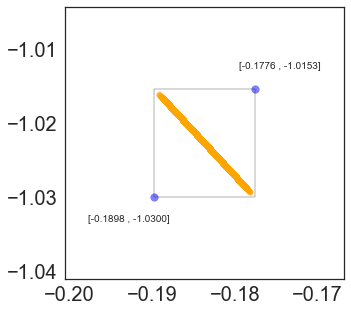

In [794]:
## plot the out points (red points)
# wheather it is over the upper/lower bound points (blue points)

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(out[:,0],out[:,1],s=30,c='orange',marker='o',alpha=0.5,label='C1')
ax.scatter(zl[0],zl[1],s=60,c='blue',marker='o',alpha=0.5,label='C1')
ax.scatter(zu[0],zu[1],s=60,c='blue',marker='o',alpha=0.5,label='C1')

ax.text(zl[0]-0.003, zl[1]-0.003, "[%.4f , %.4f]"%(zl[0],zl[1]), ha="center", va="center", size=10)
ax.text(zu[0]+0.003, zu[1]+0.003, "[%.4f , %.4f]"%(zu[0],zu[1]), ha="center", va="center", size=10)

ax.add_patch(patches.Rectangle((zl[0], zl[1]), zu[0]-zl[0], zu[1]-zl[1], fill=False))

In [585]:
w = model[3].weight
b = model[3].bias
w

zM_u = 0.9708
zM_l = 0.5358

u1 = (w[0][0]*zM_l + b[0]).data.numpy()
u2 = (w[1][0]*zM_u + b[1]).data.numpy()

l1 = (w[0][0]*zM_u + b[0]).data.numpy()
l1 = (w[1][0]*zM_l + b[1]).data.numpy()
w

Parameter containing:
tensor([[ 0.9887],
        [-0.0486]], requires_grad=True)

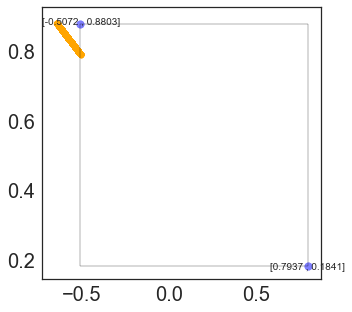

In [305]:
## plot the out points (red points)
# wheather it is over the upper/lower bound points (blue points)

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(out[:,0],out[:,1],s=30,c='orange',marker='o',alpha=0.5,label='C1')

ax.scatter(l1,l2,s=60,c='blue',marker='o',alpha=0.5,label='C1')
ax.scatter(u1,u2,s=60,c='blue',marker='o',alpha=0.5,label='C1')

ax.text(l1-0.003, l2-0.003, "[%.4f , %.4f]"%(l1,l2), ha="center", va="center", size=10)
ax.text(u1+0.003, u2+0.003, "[%.4f , %.4f]"%(u1,u2), ha="center", va="center", size=10)

ax.add_patch(patches.Rectangle((l1, l2), u1-l1, u2-l2, fill=False))

In [886]:
a = torch.load('maxpool_x_.pt')
a

tensor([[[0.4878, 1.1139, 0.6698]]])